[0.009760379791259766, 0.010207891464233398, 0.010589122772216797, 0.010648012161254883, 0.010639190673828125, 0.00890493392944336, 0.01046299934387207, 0.009325742721557617, 0.009798765182495117, 0.009157896041870117]


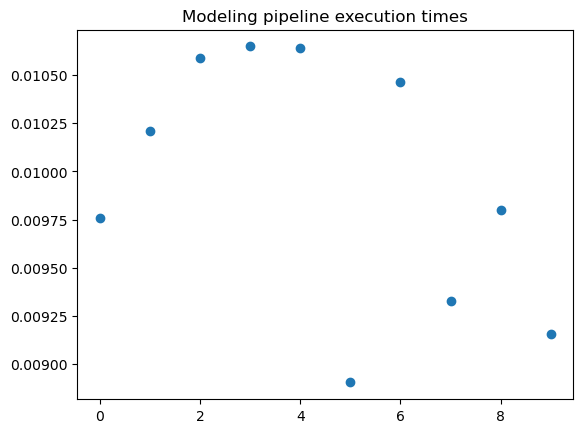

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta, datetime

execution_times = []

for j in range(10):
    execution_start_time = time.time()

    for i in range(100000):
        sum = i + 19

    execution_end_time = time.time()
    execution_time = execution_end_time - execution_start_time
    execution_times.append(execution_time)

print(execution_times)

plt.scatter(np.arange(0, len(execution_times)), execution_times)
plt.title('Modeling pipeline execution times')
plt.savefig('modeling_pipeline_execution_times.png')
np.save('modeling_pipeline_execution_times', execution_times)